In [1]:
import copy
from argparse import Namespace
import numpy as np
import matplotlib.pyplot as plt

from bax.models.simple_gp import SimpleGp
from bax.alg.algorithms import Dijkstras
from bax.acq.acqoptimize import AcqOptimizer

from typing import List
from bax.util.graph import Vertex, make_vertices, make_edges, farthest_pair, edges_of_path, positions_of_path

import neatplot
neatplot.set_style('fonts')

In [2]:
# Set random seed
seed = 0
np.random.seed(seed)

In [3]:
def softplus(x):
    return np.log1p(np.exp(x))

def inv_softplus(x):
    return np.log(np.exp(x) - 1)

In [4]:
def make_grid(grid_size, x1_lims=(-1, 1), x2_lims=(-1, 1)):
    grid_size = 10
    x1, x2 = np.meshgrid(np.linspace(*x1_lims, grid_size), np.linspace(*x2_lims, grid_size))
    positions = np.stack([x1.flatten(), x2.flatten()], axis=-1)
    n = len(positions)

    has_edge = [[False for _ in range(n)] for _ in range(n)]
    for i in range(n):
        for j in range(i + 1, n):
            if ((abs(i - j) == 1) and (j % grid_size != 0)): # neighbors cardinal directions
                has_edge[i][j] = True
            elif (abs(i - j) == grid_size): # vertices on the edge of grid
                has_edge[i][j] = True
            elif (abs(j - i) == grid_size + 1) and (j % grid_size != 0): # diagonals
                has_edge[i][j] = True
            elif (abs(j - i) == grid_size - 1) and (i % grid_size != 0): # diagonals
                has_edge[i][j] = True
            else:
                has_edge[i][j] = False
    has_edge = np.array(has_edge)
    
    vertices = make_vertices(positions, has_edge)
    edges = make_edges(vertices)
    
    return positions, vertices, edges

In [5]:
def grid_to_array(*components):
    return np.stack([c.flatten() for c in components], axis=-1)

def array_to_grid(arr):
    # assumes arr contains points on a grid in last-dim-major order
    assert arr.ndim == 2
    n, d = arr.shape
    grid_size = int(n ** (1/d))
    components = tuple(arr.T)
    return tuple(c.reshape(*(grid_size for _ in range(d))) for c in components)

In [6]:
def cost_func(u: Vertex, v: Vertex, f, latent_f=True):
    u_pos, v_pos = u.position, v.position
    edge = (u_pos + v_pos) / 2
    edge_cost = f(edge)
    if latent_f:
        return softplus(edge_cost), [edge], [edge_cost]
    else:
        return edge_cost, [edge], [edge_cost]

def cost_of_path(path, cost_func):
    cost = 0
    for i in range(len(path) - 1):
        cost += cost_func(path[i], path[i+1])
    return cost

def plot_path(ax, path, path_color=(0, 0, 0, 1.), linewidths=2, linestyle="dotted", plot_vertices=False):
    from matplotlib.collections import LineCollection as LC
    # plot path taken
    path_lines = edges_of_path(path)
    path_lc = LC(path_lines, colors=[path_color] * len(path_lines), linewidths=linewidths, linestyle=linestyle)
    ax.add_collection(path_lc)
    
    # plot visited vertices
    if plot_vertices:
        ax.scatter(*positions_of_path(path).T, color=(0, 0, 0, 1))
    return

def plot_vertices(ax, vertices, **kwargs):
    ax.scatter(*positions_of_path(vertices).T, color=(0, 0, 0, 1), **kwargs)
    return

def plot_graph(ax, edges, start: Vertex, goal: Vertex):
    from matplotlib.collections import LineCollection as LC
    # plot edges
    color = (0.75, 0.75, 0.75, 0.1)
    lc = LC(edges, colors=[color] * len(edges), linewidths=1.0)
    ax.add_collection(lc)

    # plot vertices
    ax.scatter(*positions.T, color=(0, 0, 0, 1), facecolors='none')

    # plot start and goal vertices
    ax.scatter(*start.position, color='g', label="Start", s=100)
    ax.scatter(*goal.position, color='r', label="Goal", s=100)
    
    ax.grid(False)
    ax.legend()
    return

def plot_contourf(fig, ax, x1_lims, x2_lims):
    x, y = np.meshgrid(np.linspace(*x1_lims), np.linspace(*x2_lims))
    
    # plot cost function
    cs = ax.contourf(x, y, rosenbrock(x, y), cmap='BuGn')
    cbar = fig.colorbar(cs)

In [7]:
def run_experiment(initial_xs, n_iter, n_path, plot=False):
    # Set data for model
    data = Namespace()
    data.x = initial_xs
    data.y = [true_latent_f(x) for x in data.x]

    # Set model as a GP
    gp_params = {'ls': 1.0, 'alpha': 1.0, 'sigma': 1e-2}
    model = SimpleGp(gp_params)
    model.set_data(data)
    
    outputs_of_iter = []
    queried_xs = []
    x_test = positions

    for i in range(n_iter):
        # Optimize acquisition function
        acqopt = AcqOptimizer({'n_path': n_path,
                               'viz_acq': False})
        arg_x_next = acqopt.optimize(model, algo, x_test, return_argmax=True)

        sampled_outputs = acqopt.get_last_output_list()
        outputs_of_iter.append(sampled_outputs)

        # Query function, update data
        x_next = x_test[arg_x_next]
        y_next = true_latent_f(x_next)
        data.x.append(x_next)
        data.y.append(y_next)

        # Update physical path taken
        next_vertex = vertices[arg_x_next]
        queried_xs.append(next_vertex)

        # Update model
        model = SimpleGp(gp_params)
        model.set_data(data)

        # plots
        if plot:            
            fig, ax = plt.subplots(figsize=(9, 6))

            plot_contourf(fig, ax, x1_lims, x2_lims)

            plot_graph(ax, edges, start, goal)

            
            if len(queried_xs[:-1]) > 0:
                plot_vertices(ax, queried_xs[:-1], label='Given')
            
            ax.set(ylim=[-1.2, 4.2], xlim=[-2.2, 2.2]) # TODO: replace hard coded values
            ax.legend()

            min_costs, min_cost_paths = zip(*sampled_outputs)
            n = acqopt.params.n_path
            for path in min_cost_paths:
                plot_path(ax, path, path_color=(0, 0, 1, 1/n), linewidths=2, linestyle="-")

            # make matplotlib plot within for loop. See: https://stackoverflow.com/questions/19766100/real-time-matplotlib-plot-is-not-working-while-still-in-a-loop
            plt.pause(0.0001)

        print(f'Acq optimizer x_next = {next_vertex}')
        print(f'Finished iter i = {i}')
    
    return outputs_of_iter

In [8]:
# Set function
def rosenbrock(x, y, a=1, b=100):
    # rescaled to improve numerics
    return 1e-2 * ((a - x)**2 + b * (y - x**2)**2)
# min cost path: 1.0527267184880365

def true_f(x_y):
    return rosenbrock(x_y[..., 0], x_y[..., 1])

def true_latent_f(x_y):
    return inv_softplus(true_f(x_y))

In [9]:
grid_size = 10
x1_lims = (-2, 2)
x2_lims = (-1, 4)
positions, vertices, edges = make_grid(grid_size, x1_lims, x2_lims)

start, goal = vertices[-grid_size], vertices[-1]
print(f"Start position: {start.position}")
print(f"Goal position: {goal.position}")

algo = Dijkstras({
    'start': start,
    'goal': goal,
    'vertices': vertices,
    'cost_func': lambda u, v, f: cost_func(u, v, f, latent_f=True),
    'true_cost': lambda u, v: cost_func(u, v, true_f, latent_f=False)}
)

initial_xs = []
#permutations = np.random.permutation(len(positions))
#data.x = [positions[i] for i in permutations[:10]]

Start position: [-2.  4.]
Goal position: [2. 4.]
*[INFO] Dijkstras with params=Namespace(cost_func=<function <lambda> at 0x7ff0bbc85dc0>, goal=(99, [88, 89, 98]), name='Dijkstras', start=(90, [80, 81, 91]), true_cost=<function <lambda> at 0x7ff0bbc85700>, vertices=[(0, [1, 10, 11]), (1, [0, 2, 10, 11, 12]), (2, [1, 3, 11, 12, 13]), (3, [2, 4, 12, 13, 14]), (4, [3, 5, 13, 14, 15]), (5, [4, 6, 14, 15, 16]), (6, [5, 7, 15, 16, 17]), (7, [6, 8, 16, 17, 18]), (8, [7, 9, 17, 18, 19]), (9, [8, 18, 19]), (10, [0, 1, 11, 20, 21]), (11, [0, 1, 2, 10, 12, 20, 21, 22]), (12, [1, 2, 3, 11, 13, 21, 22, 23]), (13, [2, 3, 4, 12, 14, 22, 23, 24]), (14, [3, 4, 5, 13, 15, 23, 24, 25]), (15, [4, 5, 6, 14, 16, 24, 25, 26]), (16, [5, 6, 7, 15, 17, 25, 26, 27]), (17, [6, 7, 8, 16, 18, 26, 27, 28]), (18, [7, 8, 9, 17, 19, 27, 28, 29]), (19, [8, 9, 18, 28, 29]), (20, [10, 11, 21, 30, 31]), (21, [10, 11, 12, 20, 22, 30, 31, 32]), (22, [11, 12, 13, 21, 23, 31, 32, 33]), (23, [12, 13, 14, 22, 24, 32, 33, 34]), (2

*[INFO] SimpleGp with params=Namespace(alpha=1.0, kernel=<function kern_exp_quad at 0x7ff0ea68f430>, ls=1.0, name='SimpleGp', sigma=0.01)
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after 95 expansions and 656 queries with estimated cost 5.317685598376
true cost 17.34195701874715
Found goal after 60 expansions and 419 queries with estimated cost 6.027610375392472
true cost 31.04139460448104
Found goal after 57 expansions and 404 queries with estimated cost 2.9423764495602653
true cost 43.95634659350711
Found goal after 80 expansions and 564 queries with estimated cost 7.898499259102325
true cost 69.17582533150434
Found goal after 87 expansions and 606 queries with estimated cost 9.285446104460497
true cost 77.01876085962506
Found goal after 63 expansions and 440 queries with estimated cost 3.6089431434295216
true cost 49.992011888431655
Found goal after 99 expansions and 678 queries wi

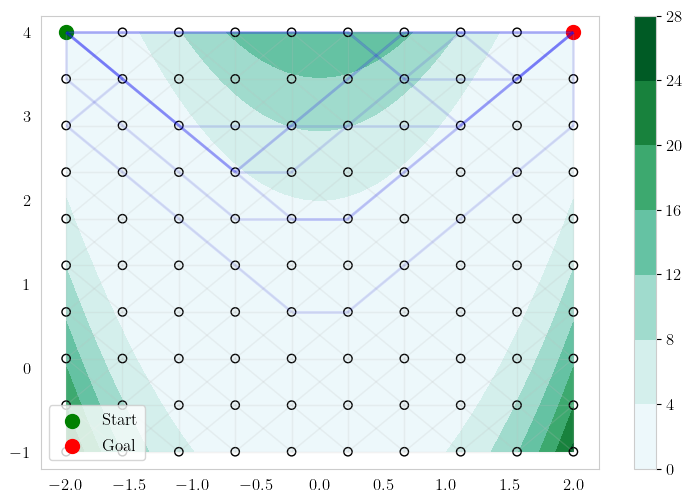

Acq optimizer x_next = (73, [62, 63, 64, 72, 74, 82, 83, 84])
Finished iter i = 0
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after 97 expansions and 660 queries with estimated cost 16.11637017847755
true cost 24.929830818472805
Found goal after 100 expansions and 681 queries with estimated cost 23.40094881154319
true cost 14.912190214906262
Found goal after 92 expansions and 629 queries with estimated cost 14.608895239527287
true cost 12.087244322511813
Found goal after 85 expansions and 570 queries with estimated cost 16.86445818728122
true cost 75.47212162780065
Found goal after 98 expansions and 671 queries with estimated cost 20.063545468122953
true cost 13.41385002286237
Found goal after 91 expansions and 623 queries with estimated cost 22.04899539761202
true cost 14.83219021490626
Found goal after 86 expansions and 581 queries with estimated cost 9.680299279613514
true cost 15.6

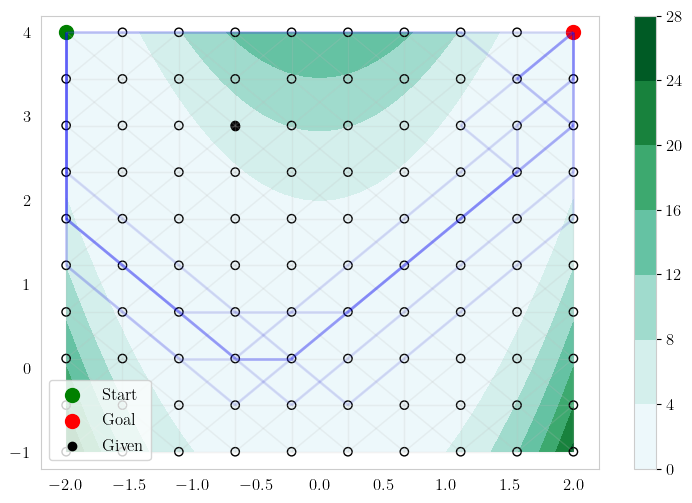

Acq optimizer x_next = (42, [31, 32, 33, 41, 43, 51, 52, 53])
Finished iter i = 1
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after 94 expansions and 642 queries with estimated cost 14.402899420753943
true cost 16.45996037189453
Found goal after 95 expansions and 653 queries with estimated cost 14.9576743547474
true cost 9.69245084590764
Found goal after 90 expansions and 616 queries with estimated cost 11.92281072304396
true cost 16.054741655235485
Found goal after 89 expansions and 608 queries with estimated cost 11.57272545990011
true cost 14.199172382258803
Found goal after 91 expansions and 624 queries with estimated cost 14.456264126497048
true cost 15.708376771833567
Found goal after 86 expansions and 593 queries with estimated cost 12.312049798655313
true cost 17.14870598994056
Found goal after 89 expansions and 608 queries with estimated cost 9.52623032598628
true cost 8.18324

KeyboardInterrupt: 

In [10]:
outputs_of_iters = run_experiment([], 10, 10, plot=True)
estimated_costs = [[output[0] for output in output_samples] for output_samples in outputs_of_iters]
true_costs = [[cost_of_path(output[1], lambda u, v: algo.params.true_cost(u, v)[0]) for output in output_samples]for output_samples in outputs_of_iters]

In [ ]:
estimated_costs = np.array(estimated_costs)
true_costs = np.array(true_costs)

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.arange(10), estimated_costs.mean(-1), 'o', label="Estimated cost of samples")
ax.plot(np.arange(10), true_costs.mean(-1), 'o', label="True cost of samples")
ax.legend()